In [206]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams['figure.figsize'] = [12, 9]
import scipy.optimize as opt
import torch
import torch.nn as nn

In [122]:
def quant(x, alpha, bits):
    qmax = 2 ** bits - 1
    qmin = 0
    
    delta = 2 * alpha / qmax
    
    tq = (x + alpha) / delta
    tq = torch.clamp(tq, qmin, qmax)
    tq = torch.round(tq)
    tq = tq * delta - alpha
    
    return tq

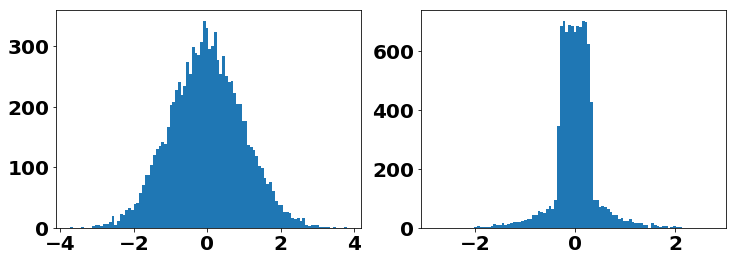

In [219]:
np.random.seed(0)
plt.rcParams['figure.figsize'] = [12, 4]
x = torch.tensor(np.random.normal(size=10000), dtype=torch.float).cuda()
plt.subplot(1, 2, 1)
plt.hist(x.cpu().flatten(), bins=100);
plt.subplot(1, 2, 2)
xq = quant(x, 1., 2) - x
plt.hist(xq.cpu().flatten(), bins=100);

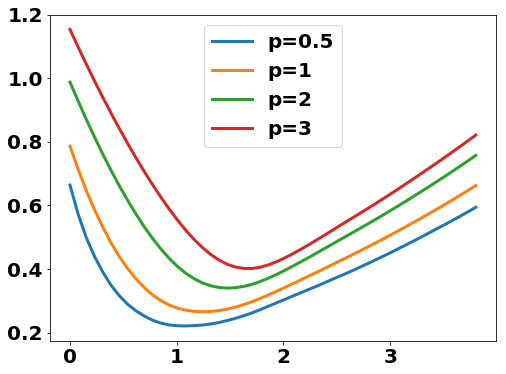

In [220]:
def lp_norm(x, p):
    return (torch.mean(torch.abs(x)**p))**(1./p)

plt.rcParams['figure.figsize'] = [8, 6]
ps = [0.5, 1, 2, 3]
clips = np.linspace(0., x.max().item(), 50)
for p in ps:
    plt.plot(clips, [lp_norm(x - quant(x, c, bits=2), p=p).item() for c in clips], linewidth=3);
    
plt.legend(["p={}".format(p) for p in ps]);

clip range 10.51%


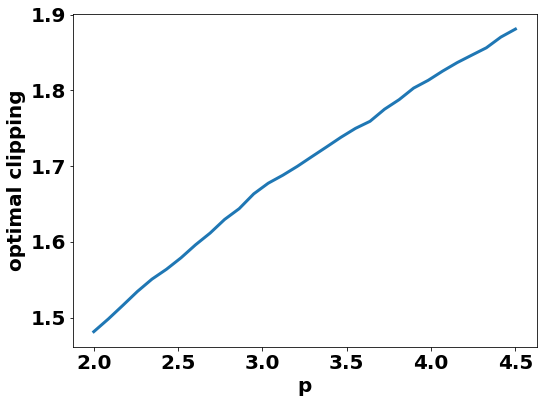

In [221]:
plt.rcParams['figure.figsize'] = [8, 6]
font = {'weight' : 'normal', 'size': 20, 'weight': 'bold'}
matplotlib.rc('font', **font)

def quant_error(x, c, p, bits=2):
    return lp_norm(x - quant(x, c, bits=bits), p=p)

ps = np.linspace(2, 4.5, 30)
c_opt = [opt.minimize_scalar(lambda c: quant_error(x, c, p).item()).x for p in ps]
plt.plot(ps, c_opt, linewidth=3);
# plt.axhline(x.max().item(), ls='--')
plt.xlabel("p", fontsize=20, weight='bold')
plt.ylabel("optimal clipping", fontsize=20, weight='bold');
print("clip range {:.2f}%".format(100*(np.max(c_opt) - np.min(c_opt))/x.max().item()))
plt.tight_layout()
plt.savefig('../fig/p_vs_opt_clipping.pdf')